In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import numpy as np
from matplotlib import pyplot as plt

In [85]:
from random_features import RFF

In [86]:
sampler = lambda shape: multivariate_normal(mean=[0]*3, cov=np.eye(3)).rvs(size=np.product(shape))

In [87]:
n_features = 20
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=3)

In [88]:
pts = np.arange(0, 1, 0.1).reshape(-1, 1).repeat(3, axis=1)

In [89]:
features = rff.get_random_features(pts)

In [90]:
assert features.shape == (len(pts), n_features)

In [91]:
from data_utils import Landscape

In [92]:
landscape = Landscape()
landscape.initialize()

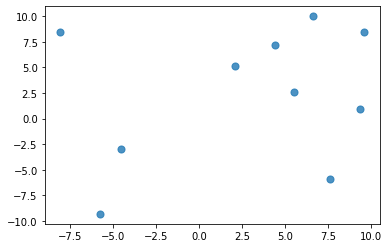

In [93]:
plt.scatter(landscape.landmarks[:, 0], landscape.landmarks[:, 1], s=50, alpha=0.8)

In [569]:
from data_utils import Odometry

N_pts = 10

odometry = Odometry(landscape, observation_dim=3, max_time=1000)
odometry.generate(N_pts)

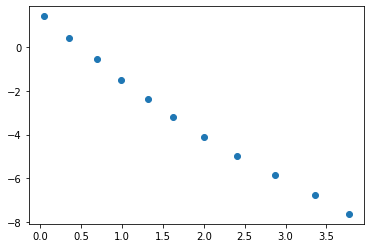

In [570]:
plt.scatter(np.array(odometry.states)[:, 0], np.array(odometry.states)[:, 1])

In [573]:
from model import Model
from observation import RangeModel 
from data_utils import get_prediction


sampler = lambda shape: multivariate_normal(mean=[0], cov=(1./3**2)*np.eye(1)).rvs(size=np.product(shape))

n_features = 100
assert n_features % 2 == 0
rff = RFF(n_features=n_features // 2, w_sampler=sampler, dim=1)

#initial_values = np.zeros((n_features*3)+2*len(landscape.landmarks))

range_model = RangeModel(odometry.Q[0,0])

def prior_mean(t, state_estimates):
    i = odometry.times.index(t)
    state = get_prediction(state_estimates[i], odometry.motions[i])
    return state

initial_values = np.concatenate([np.zeros(n_features*3), landscape.landmarks.reshape(-1)])
b_means = np.concatenate([np.zeros(n_features*3), landscape.landmarks.reshape(-1)])


model = Model(rff=rff, 
              initial_values=initial_values,
              initial_state=odometry.states[0],
              times=odometry.times,
              measurements=np.stack(odometry.observations, 0)[:, 0, [0, 2]],
              measurement_covs=[odometry.Q[:1, :1]]*N_pts,
              motions=odometry.motions,
              b_means=b_means,
              b_covs=[1*np.eye(n_features)]*3,
              land_means=landscape.landmarks,
              land_cov=[1*np.eye(2)]*len(landscape.landmarks),
              observation_model=range_model,
              prior_mean=prior_mean,
              dampening_factor=100,
            )

In [574]:
model.run_slam(10)

0.42927280514898425
0.017130517585006118
0.01327876415794835
0.02798751076157961
0.06028185804922278
0.13109859781128005
0.280289442393081
0.5346803988506404
0.7454389605407727
0.8642755259411666


In [557]:
np.array(odometry.states[1:11])#, np.array(odometry.states[:10])+np.array(odometry.motions[:10])

array([[ 0.98239892, -0.00800037, -0.43632398],
       [ 1.75732988, -0.43859069, -0.44959115],
       [ 2.46264396, -0.8241168 , -0.40619953],
       [ 3.19583441, -1.1976916 , -0.36854582],
       [ 3.94636409, -1.54339703, -0.43877762],
       [ 4.69350374, -1.89729872, -0.43956455],
       [ 5.42688583, -2.33910664, -0.58095038],
       [ 6.04086539, -2.80987362, -0.7048591 ],
       [ 6.64661724, -3.40244886, -0.79700811],
       [ 7.19540608, -4.08799338, -0.92493811]])

In [558]:
model.prior_means[:10]

[array([ 0.98239892, -0.00800037, -0.43632398]),
 array([ 1.75732988, -0.43859069, -0.44959115]),
 array([ 2.46264396, -0.8241168 , -0.40619953]),
 array([ 3.19583441, -1.1976916 , -0.36854582]),
 array([ 3.94636409, -1.54339703, -0.43877762]),
 array([ 4.69350374, -1.89729872, -0.43956455]),
 array([ 5.42688583, -2.33910664, -0.58095038]),
 array([ 6.04086539, -2.80987362, -0.7048591 ]),
 array([ 6.64661724, -3.40244886, -0.79700811]),
 array([ 7.19540608, -4.08799338, -0.92493811])]

In [576]:
model.states[:10]

array([[ 0.63840491,  0.50892736, -1.2783516 ],
       [ 3.24248683,  3.80240171, -1.28766641],
       [-0.75683791, -2.27235743, -1.29752389],
       [ 6.7978498 ,  1.32796653, -1.21427174],
       [ 0.98693963, -3.30262973, -1.20098646],
       [ 0.38114923, -8.92154424, -1.1859152 ],
       [ 2.37151152, -5.81711949, -1.10424625],
       [ 0.70108534, -6.10124387, -1.07231418],
       [ 2.22783164, -6.40281656, -1.08034689],
       [11.13905383, -4.10842214, -1.06630819]])

In [539]:
model.b[300:].reshape(-1, 2), landscape.landmarks

(array([[ 5.94438904,  8.68519681],
        [ 9.10249594, -4.38387518],
        [-3.01937273, -1.50280088],
        [ 5.67368619,  4.5412521 ],
        [ 9.17797878,  9.20449895],
        [ 7.04763316,  4.09171587],
        [-6.57160624,  9.96334677],
        [-4.22556467, -7.81055546],
        [ 3.59562358,  6.58402056],
        [10.85847425,  2.40892285]]),
 array([[ 4.45459155,  7.19539933],
        [ 7.61269846, -5.87367266],
        [-4.50917021, -2.99259836],
        [ 6.66154409,  9.99118772],
        [ 9.6116792 ,  8.4330551 ],
        [ 5.55783568,  2.60191839],
        [-8.06140372,  8.47354928],
        [-5.71536215, -9.30035295],
        [ 2.1058261 ,  5.09422307],
        [ 9.36867676,  0.91912537]]))

In [272]:
model.features

array([[[ 0.969995  ,  0.97809101,  0.82060684, ...,  0.45494478,
          0.33077325, -0.11381908],
        [ 0.92735534,  0.87184143,  0.98362577, ...,  0.53207618,
         -0.37962975, -0.04458355],
        [ 0.98129826,  0.94318414,  0.85049621, ...,  0.15562848,
          0.23713522, -0.70623531]],

       [[ 0.93701976,  0.9428437 ,  0.96612027, ...,  0.74275576,
         -0.58399203, -0.80650874],
        [ 0.84252161,  0.53191283, -0.33121993, ...,  0.14206518,
         -0.71390702, -0.99332412],
        [ 0.11332544,  0.87166363,  0.81460897, ...,  0.99506637,
         -0.23668206, -0.13800329]],

       [[ 0.62036038,  0.68046834,  0.73205437, ...,  0.42183284,
         -0.79414936, -0.46973612],
        [ 0.5737893 ,  0.15725025,  0.80496555, ..., -0.26056795,
         -0.61917978, -0.99574168],
        [ 0.26428213,  0.52118569,  0.8545692 , ...,  0.79550125,
         -0.46256978,  0.29181416]],

       ...,

       [[ 0.06801524, -0.99969245,  0.86839535, ...,  0.9685936